In [2]:
# importing necessary package

import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

# importing modules from source

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils
import src.loader as loader

In [3]:
# Data acquisition
# we use slack data

data_loader = SlackDataLoader("C:/Users/Diriba/Desktop/10AC/Projects/week0_starter_network_analysis/anonymized")
path_channel = "C:/Users/Diriba/Desktop/10AC/Projects/week0_starter_network_analysis/anonymized"
df = data_loader.slack_parser(path_channel)

df.head(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel_name,channel
0,message,<https://towardsdatascience.com/how-to-fill-mi...,Anthony Galloway,1661158502.784099,link,0,0,0,0,0,all-week1,anonymized
1,message,"Imputation Using k-NN, Imputation Using Multiv...",Katie Dickerson,1661158692.172369,text,1661158692.172369,2,2,"U03U1GHT39V,U03UJGRN5E0",1661159006.632649,all-week1,anonymized
2,message,<https://towardsdatascience.com/6-different-wa...,Katie Dickerson,1661158702.777369,link,0,0,0,0,0,all-week1,anonymized
3,message,u can use SMOTE or mode to impute categorical ...,Joseph Diaz,1661158767.626859,text,1661158692.172369,0,0,0,0,all-week1,anonymized
4,message,:+1:thanks,Katie Dickerson,1661159006.632649,emoji,1661158692.172369,0,0,0,0,all-week1,anonymized
5,message,<https://www.scribbr.com/statistics/normal-dis...,Amy Leon,1661160070.855719,link,1661160070.855719,1,1,U03UFV7TUTV,1661161916.102399,all-week1,anonymized
6,message,"Any have information, on the time the next ses...",Nancy Craig,1661161636.759979,text,1661161636.759979,5,4,"U03U93GNNVB,U03U1FNPEUX,U03UG5VFN03,U03UG0YHAUT",1661170044.469879,all-week1,anonymized
7,message,Please check the schedule,Katherine Foster,1661161669.054589,text,1661161636.759979,0,0,0,0,all-week1,anonymized
8,message,<https://www.notion.so/10academy/10-Academy-Ba...,Joshua Rhodes,1661161725.970779,link,1661161636.759979,0,0,0,0,all-week1,anonymized
9,message,Thanks Natnael,Anthony Galloway,1661161916.102399,text,1661160070.855719,0,0,0,0,all-week1,anonymized


In [6]:
# print the information regarding each column in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           3342 non-null   object
 1   msg_content        3342 non-null   object
 2   sender_name        3342 non-null   object
 3   msg_sent_time      3342 non-null   object
 4   msg_dist_type      3342 non-null   object
 5   time_thread_start  3342 non-null   object
 6   reply_count        3342 non-null   int64 
 7   reply_users_count  3342 non-null   int64 
 8   reply_users        3342 non-null   object
 9   tm_thread_end      3342 non-null   object
 10  channel_name       3342 non-null   object
 11  channel            3342 non-null   object
dtypes: int64(2), object(10)
memory usage: 313.4+ KB


In [7]:
# Identify the columns with missing value

missing_values = df.isnull().sum()
print(f"Missing Values Count: \n{missing_values}")

Missing Values Count: 
msg_type             0
msg_content          0
sender_name          0
msg_sent_time        0
msg_dist_type        0
time_thread_start    0
reply_count          0
reply_users_count    0
reply_users          0
tm_thread_end        0
channel_name         0
channel              0
dtype: int64


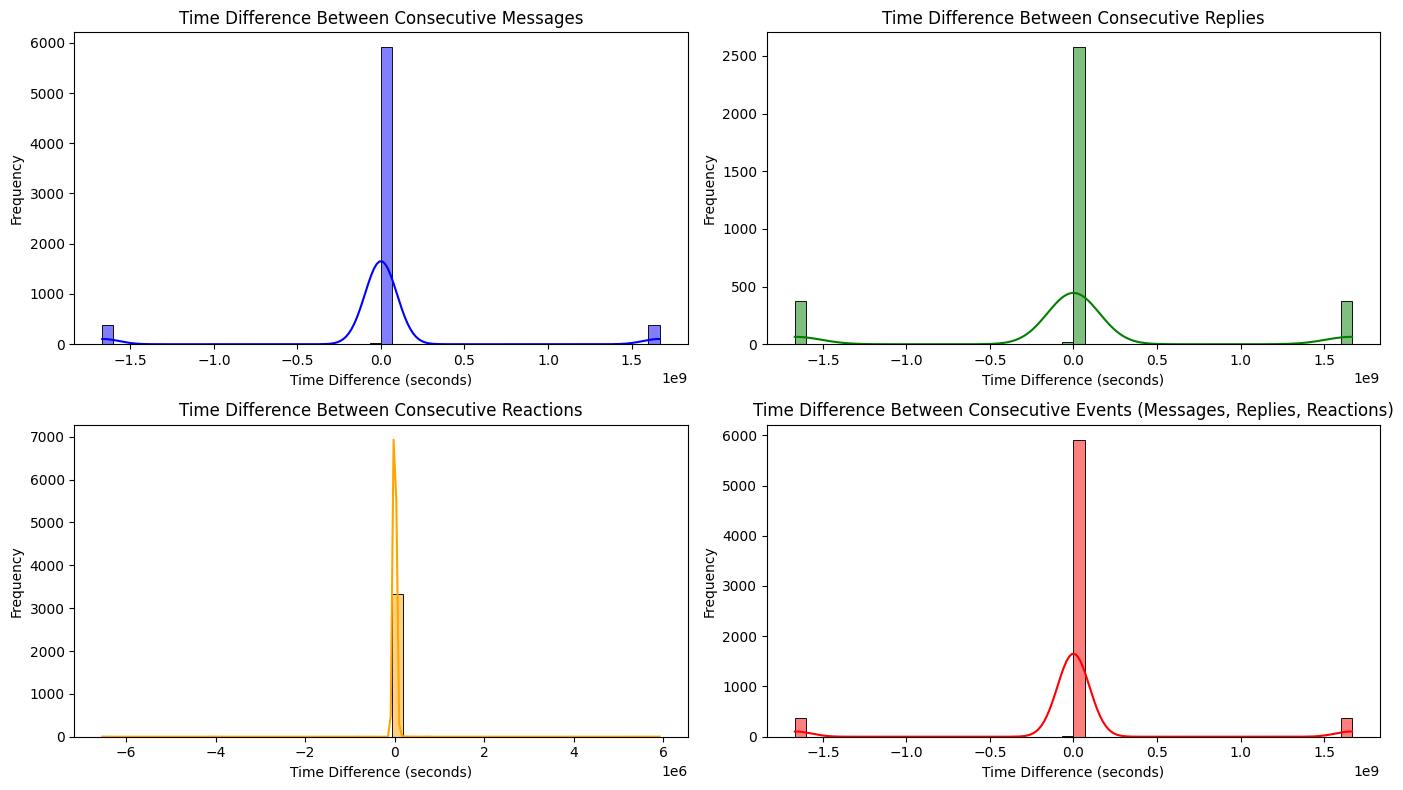

In [6]:
'''
What is the distribution of time differences between messages,
replies, reactions, and any type event (message, reply, reaction)?
■ Plot a histogram of the time difference between
● Consecutive messages
● Consecutive replies
● Consecutive reactions
● Consecutive events (message, reply, reaction)

'''

# Convert 'msg_sent_time' and 'tm_thread_end' columns to datetime objects
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'], unit='s')
df['tm_thread_end'] = pd.to_datetime(df['tm_thread_end'], unit='s')

# Calculate time differences between consecutive events
df['time_diff_messages'] = df.groupby('channel')['msg_sent_time'].diff().dt.total_seconds()
df['time_diff_replies'] = df.groupby('channel')['tm_thread_end'].diff().dt.total_seconds()

# Flatten the time differences into a single column for all events
all_time_diffs = pd.concat([df['time_diff_messages'].dropna(), df['time_diff_replies'].dropna()])

# Plot histograms
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.histplot(all_time_diffs, bins=50, kde=True, color='blue')
plt.title('Time Difference Between Consecutive Messages')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(df['time_diff_replies'].dropna(), bins=50, kde=True, color='green')
plt.title('Time Difference Between Consecutive Replies')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
# Assuming you need to calculate the time difference for reactions as well
df['time_diff_reactions'] = df.groupby('channel')['msg_sent_time'].diff().dt.total_seconds()
sns.histplot(df['time_diff_reactions'].dropna(), bins=50, kde=True, color='orange')
plt.title('Time Difference Between Consecutive Reactions')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(all_time_diffs, bins=50, kde=True, color='red')
plt.title('Time Difference Between Consecutive Events (Messages, Replies, Reactions)')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
